In [1]:
import torch
import random
import math
import hess
import hess.utils as utils
import matplotlib.pyplot as plt
from hess.nets import Transformer
import hess.loss_surfaces as loss_surfaces
from hess.data import data_loader
import numpy as np
import copy

In [2]:
def twospirals(n_points, noise=.5, random_state=920):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 600 * (2*np.pi)/360
    d1x = -1.5*np.cos(n)*n + np.random.randn(n_points,1) * noise
    d1y =  1.5*np.sin(n)*n + np.random.randn(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))),
            np.hstack((np.zeros(n_points),np.ones(n_points))))

In [3]:
X, Y = twospirals(500, noise=1.5)
test_x, test_y = twospirals(100, 1.5)

In [4]:
train_x = torch.FloatTensor(X)
train_y = torch.FloatTensor(Y).unsqueeze(-1)

test_x = torch.FloatTensor(test_x)
test_y = torch.FloatTensor(test_y).unsqueeze(-1)

In [5]:
optimus = Transformer(train_x, train_y, net=hess.nets.MoonNet, n_hidden=3, hidden_size=10,
                     activation=torch.nn.ELU(), bias=True)
network = optimus.net
loss_func = torch.nn.BCEWithLogitsLoss()

In [6]:
use_cuda =  torch.cuda.is_available()
if use_cuda:
    torch.cuda.set_device(2)
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()
    network = network.cuda()
    optimus = optimus.cuda()

In [7]:
def mask_pars(p, mask):
    p.data = p.data * mask
    
def mask_maker(n_keep, n_total, use_cuda=False):
    mask = [1 for i in range(n_keep)] + [0 for i in range(n_total - n_keep)]
    mask = torch.tensor(mask)
    perm = np.random.permutation(n_total)
    mask = mask[perm]
    if use_cuda:
        mask = mask.cuda()
    return mask, perm

In [8]:
n_trial = 50
pct_keep = .65
n_par = sum(torch.numel(p) for p in network.parameters())
n_keep = int(pct_keep * n_par)

optim = torch.optim.Adam

losses = torch.zeros(n_trial)
test_losses = torch.zeros(n_trial)
hessians = torch.zeros(n_trial, n_keep, n_keep)
for tt in range(n_trial): 
    
#     model = hess.nets.MaskedNet(train_x, train_y, bias=True, 
#                             n_hidden=5, pct_keep=0.65)

    
    ## set up the mask to generate a subnetwork ##
    temp_net = copy.deepcopy(network)
    mask, perm = mask_maker(n_keep, n_par, use_cuda)

    mask = utils.unflatten_like(mask.unsqueeze(0), temp_net.parameters())
    [mask_pars(p, mask[i]) for i, p in enumerate(temp_net.parameters())]

#     model = 
    
    ## compute the hessian of the masked network ##
    sub_hess = torch.zeros(n_par, n_par)
    for pp in range(n_par):
        base_vec = torch.zeros(n_par).unsqueeze(0)
        base_vec[0, pp] = 1.

        base_vec = utils.unflatten_like(base_vec, temp_net.parameters())
        utils.eval_hess_vec_prod(base_vec, temp_net.parameters(),
                                net=temp_net,
                                criterion=torch.nn.BCEWithLogitsLoss(),
                                inputs=train_x, targets=train_y)
        if pp == 0:
            output = utils.gradtensor_to_tensor(temp_net, include_bn=True)
            sub_hess = torch.zeros(output.nelement(), output.nelement())
            sub_hess[:, pp] = output


        sub_hess[:, pp] = utils.gradtensor_to_tensor(temp_net, include_bn=True).cpu()
    
    ## extract the indices of the hessian we care about ##
    keepers = np.array(np.where(perm < n_keep))[0]
    hessians[tt, :, :] = sub_hess[np.ix_(keepers, keepers)]

#     optimizer=optim(model.parameters(), lr=lr)

#     for step in range(n_iters):
#         optimizer.zero_grad()
#         outputs = model(train_x)

#         loss=loss_func(outputs,train_y)
#         losses[tt, step] = loss
#         loss.backward()
#         optimizer.step()
        
#         test_out = model(test_x)
#         test_loss = loss_func(test_out, test_y)


    ## now compute the losses for the subnetwork ##
    outputs = temp_net(train_x)
    losses[tt] = loss_func(outputs, train_y)
    
    outputs = temp_net(test_x)
    test_losses[tt] = loss_func(outputs, test_y)
    
    if tt%10 == 0:
        print("model ", tt, " done")

model  0  done
model  10  done
model  20  done
model  30  done
model  40  done


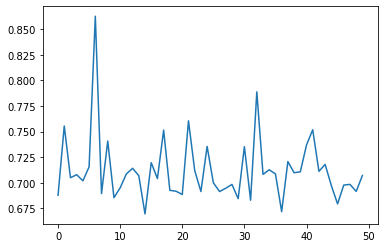

In [9]:
plt.plot(losses.detach())

In [10]:
idx = losses.argsort()
losses = losses[idx]

In [11]:
idx

tensor([14, 36, 45, 31, 29,  9,  0, 20,  7, 26, 23, 48, 19, 18, 27, 10, 44, 46,
        28, 47, 25,  4, 16,  2, 13, 49,  3, 33, 11, 35, 38, 39, 42, 22, 34, 12,
         5, 43, 15, 37, 30, 24, 40,  8, 17, 41,  1, 21, 32,  6])

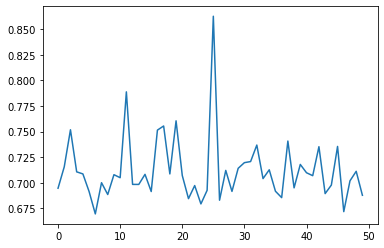

In [12]:
plt.plot(losses[idx].detach())

In [13]:
hessians = hessians[idx, :, :]

In [14]:
e_vals = torch.zeros(n_trial, n_keep)
for tt in range(n_trial):
    e_val, _ = np.linalg.eig(hessians[tt, :, :].cpu())
    idx = np.abs(e_val).argsort()[::-1]   
    e_val = torch.FloatTensor(e_val[idx].real)
    e_vals[tt, :] = e_val

In [15]:
x_plt = torch.zeros_like(e_vals)
for tt in range(n_trial):
    x_plt[tt, :] = tt

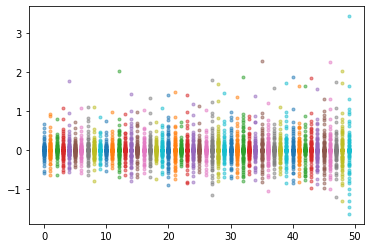

In [16]:
for tt in range(n_trial):
    plt.plot(x_plt[tt, :], e_vals[tt, :],
            marker='.', alpha=0.5, linestyle='None')

In [17]:
mean_eval = torch.mean(e_vals, 1)

In [18]:
mean_eval.shape

torch.Size([50])

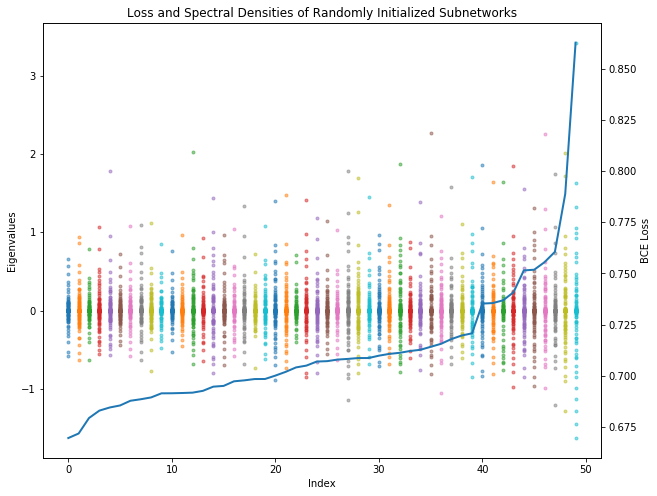

In [19]:
fig, ax1 = plt.subplots(figsize=(10,8))
for tt in range(n_trial):
    ax1.plot(x_plt[tt, :], e_vals[tt, :],
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Eigenvalues")


ax2 = ax1.twinx()
ax2.plot(x_plt[:, 0], losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Spectral Densities of Randomly Initialized Subnetworks");

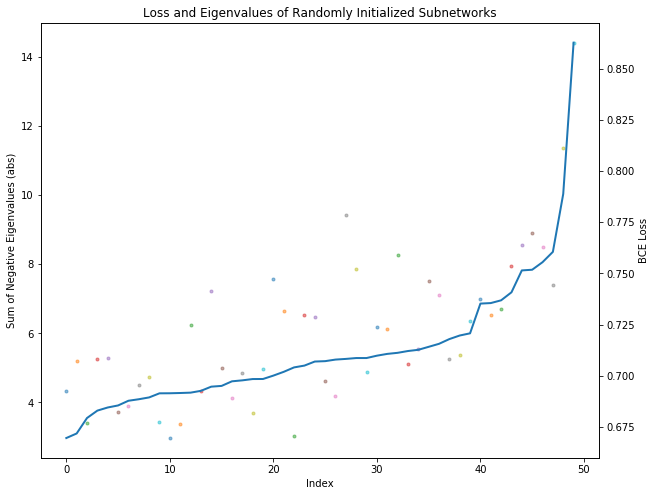

In [22]:
fig, ax1 = plt.subplots(figsize=(10,8))
for tt in range(n_trial):
    ax1.plot(x_plt[tt, 0], sum(e_vals[tt, e_vals[tt, :] < 0].abs()),
            marker=".", alpha=0.5, linestyle='None')
ax1.set_ylabel("Sum of Negative Eigenvalues (abs)")


ax2 = ax1.twinx()
ax2.plot(x_plt[:, 0], losses.detach(),
        linewidth=2.)
ax2.set_ylabel("BCE Loss")
ax1.set_xlabel("Index")
plt.title("Loss and Eigenvalues of Randomly Initialized Subnetworks");

In [21]:
outputs = optimus(train_x.cpu())
outputs = torch.zeros_like(outputs)
ll = loss_func(outputs, train_y.cpu())